<a href="https://colab.research.google.com/github/SaraShahzad1/Seoul-Bike-Sharing-Demand-Prediction/blob/main/Seoul_Bike_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing Demand Prediction

## Phase 0: Setup & Reproducibility
## Phase 1: Data Loading
## Phase 2: Preprocessing & Feature Engineering
## Phase 3: Ridge Regression
## Phase 4: Random Forest
## Phase 5: TensorFlow Neural Network
## Phase 6: Evaluation & Comparison
# ------------------------------------------------------------------------------

###Phase 0: Setup and Reproducibility

In [ ]:
import numpy as np  # For mathematical calculations
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For plotting results and outputs
import seaborn as sns  # To work with matplotlib for improved plotting

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV  # 1. To split data into Splits data into: training, validation, testing. 2. For ridge regression hyperparameter tuning. 3. For randon forest hyperparameter tuning.
from sklearn.preprocessing import StandardScaler  # Feature scaling to centered around 0 - for ridge regression and tensorflow so gradients can be calculated easily
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  #For fair comparison between the different models - Evaluation metrics

from sklearn.linear_model import Ridge  # Classical model 1
from sklearn.ensemble import RandomForestRegressor  # Classical model 2

import tensorflow as tf # Deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization  # 1. Fully connected layers. 2. To prevent oerfitting. 3. Stabalizes and speeds training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Stops training when minima in loss is reached

from scipy.stats import ttest_rel  # For comparison of two models on same test set

In [ ]:
# Same train/test split, same NN initialization and same results on rerun
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

###Phase 1: Data loading

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

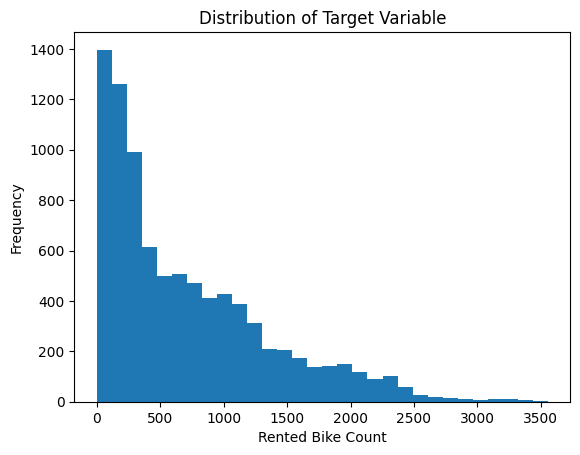

In [ ]:
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')  # Dataset was downloaded using latin-1 encoding instead of UTF-8 encoding so need to specify

df.head()
df.shape
df.info()  # For display of datatypes
df.describe()  # To decribe scale and distribution
df['Rented Bike Count'].head()
df.isnull().sum()

plt.hist(df['Rented Bike Count'], bins=30)  # Displays 30 histograms
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

Numerical:	Temperature, Humidity

Categorical:	Seasons, Holiday

Temporal:	Date, Hour

###Phase 2: Preprocessing & Feature Engineering

In [ ]:
df.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')  # Converting the date column feature to an acceptable format
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df.drop(columns=['Date'], inplace=True)  # Modifying the orignal dataset by removing the Date feature as it will be unused and useful components have been extracted

# Encoding of temporal features like seasons, holiday and functioning day to be represented as numerical values instead of text
df = pd.get_dummies(df, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=True)  # Converts categorical variables into a set of binary dummy (indicator) variables in a process known as one-hot encoding
                                                                                             # drop_first=True allows to remove redundant feature resulted from the encoding and avoid multicollienearity (important for ridge regression - linear models)

In [ ]:
X = df.drop('Rented Bike Count', axis=1)  # Remove the output feature
y = df['Rented Bike Count']

# 70% training, 15% validation (hyperparameter tuning), 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=SEED)  # 70% train set, 30% test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=SEED)  # Division of test set into 50% validation and 50% testing set

# Scaling - needed for ridge regression and NN
scaler = StandardScaler()  # Calculates mean and standard deviation

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print(df.head())  # Updated dataset after feature engineering

   Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm)  Day  Month  Weekday  Seasons_Spring  \
0        

###Phase 3: Ridge Regression

In [ ]:
ridge = Ridge()

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')  # 5 fold cross-validation (cv)

grid_ridge.fit(X_train_scaled, y_train)  # Finding best hyperparameter

print("Best alpha:", grid_ridge.best_params_)

Best alpha: {'alpha': 10}


In [ ]:
# Training ridge model
best_ridge = grid_ridge.best_estimator_
best_ridge.fit(X_train_scaled, y_train)

y_pred_ridge = best_ridge.predict(X_test_scaled)

In [ ]:
# Calculating different performance metrics
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge  = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge   = r2_score(y_test, y_pred_ridge)

print("Ridge RMSE:", rmse_ridge)
print("Ridge MAE:", mae_ridge)
print("Ridge R2:", r2_ridge)

Ridge RMSE: 430.9053220076354
Ridge MAE: 324.34561359412936
Ridge R2: 0.5410453121021492


###Phase 4: Random Forest

In [ ]:
rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)

param_dist_rf = {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

random_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf, n_iter=10,cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=SEED)

random_rf.fit(X_train, y_train)

print("Best RF params:", random_rf.best_params_)

Best RF params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


In [ ]:
best_rf = random_rf.best_estimator_
best_rf.fit(X_train, y_train)

y_pred_rf = best_rf.predict(X_test)

In [ ]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

print("RF RMSE:", rmse_rf)
print("RF MAE :", mae_rf)
print("RF R2  :", r2_rf)

RF RMSE: 175.23829735349815
RF MAE : 99.2737022239134
RF R2  : 0.9240960907210362


###Phase 5: Neural Networks

In [ ]:
X_train_dl = X_train_scaled
X_val_dl   = X_val_scaled
X_test_dl  = X_test_scaled

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dl.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [ ]:
history = model.fit(X_train_dl, y_train, validation_data=(X_val_dl, y_val), epochs=100, batch_size=32, callbacks=[early_stop, lr_scheduler], verbose=1)

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 873651.6875 - mae: 691.1228 - val_loss: 734690.0625 - val_mae: 631.2572 - learning_rate: 0.0010
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 536205.3750 - mae: 534.8021 - val_loss: 220039.7500 - val_mae: 323.2067 - learning_rate: 0.0010
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 185439.5781 - mae: 303.2690 - val_loss: 128957.3906 - val_mae: 252.6759 - learning_rate: 0.0010
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 146513.8906 - mae: 275.0988 - val_loss: 119293.4766 - val_mae: 234.9427 - learning_rate: 0.0010
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 132784.3594 - mae: 259.2000 - val_loss: 109449.7656 - val_mae: 223.9352 - learning_rate: 0.0010
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 125466.7734 - mae: 252.8467 - val_loss: 105377.5625 - val_mae: 218.1900 - learning_rate: 0.0010
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - los

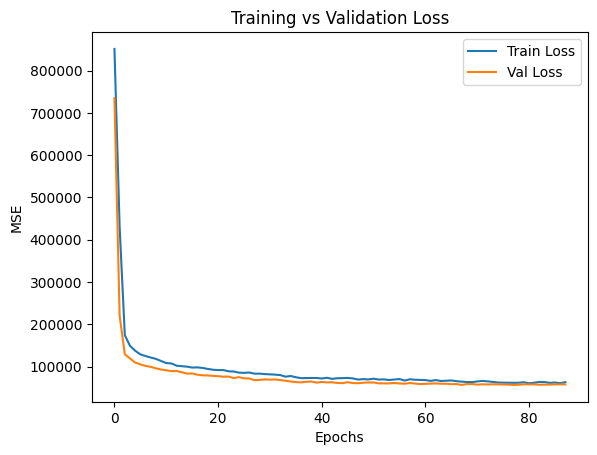

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_dl = model.predict(X_test_dl).flatten()

rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))
mae_dl  = mean_absolute_error(y_test, y_pred_dl)
r2_dl   = r2_score(y_test, y_pred_dl)

print("DL RMSE:", rmse_dl)
print("DL MAE :", mae_dl)
print("DL R2  :", r2_dl)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
DL RMSE: 223.0760100279723
DL MAE : 134.4293212890625
DL R2  : 0.8769980669021606


###Phase 6: Evaluation & Comparison

In [ ]:
results = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest', 'Deep Learning'],
    'RMSE': [rmse_ridge, rmse_rf, rmse_dl],
    'MAE':  [mae_ridge, mae_rf, mae_dl],
    'R2':   [r2_ridge, r2_rf, r2_dl]
})

results

,Model,RMSE,MAE,R2
0,Ridge Regression,430.905322,324.345614,0.541045
1,Random Forest,175.238297,99.273702,0.924096
2,Deep Learning,223.076010,134.429321,0.876998


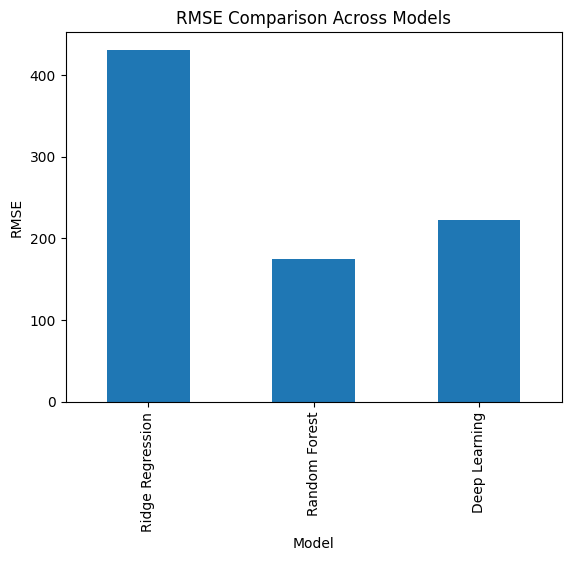

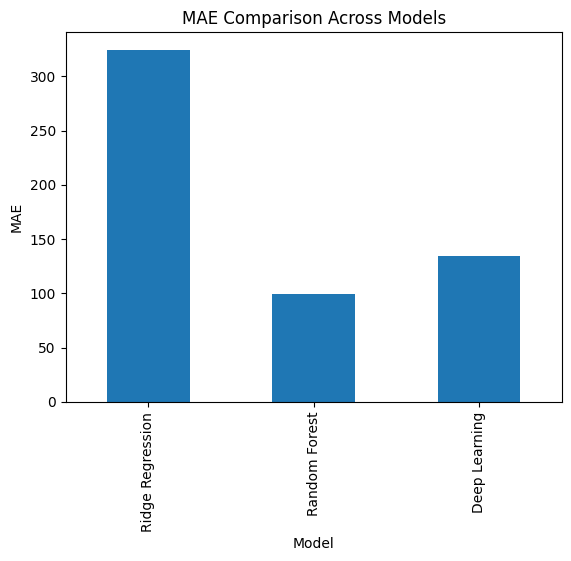

In [ ]:
results.set_index('Model')['RMSE'].plot(kind='bar')
plt.ylabel('RMSE')
plt.title('RMSE Comparison Across Models')
plt.show()

results.set_index('Model')['MAE'].plot(kind='bar')
plt.ylabel('MAE')
plt.title('MAE Comparison Across Models')
plt.show()

In [ ]:
# Statistical Significance Testing
errors_ridge = (y_test - y_pred_ridge) ** 2
errors_rf    = (y_test - y_pred_rf) ** 2
errors_dl    = (y_test - y_pred_dl) ** 2

t_dl_rf, p_dl_rf = ttest_rel(errors_dl, errors_rf)
print("NN vs RF p-value:", p_dl_rf)

t_dl_ridge, p_dl_ridge = ttest_rel(errors_dl, errors_ridge)
print("NN vs Ridge p-value:", p_dl_ridge)

# p < 0.05 → difference is statistically significant
# p ≥ 0.05 → difference may be due to chance

NN vs RF p-value: 2.674177791932804e-07
NN vs Ridge p-value: 3.19987824623505e-52
